In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import calendar


# Optional: set matplotlib inline if using a Jupyter Notebook
%matplotlib inline

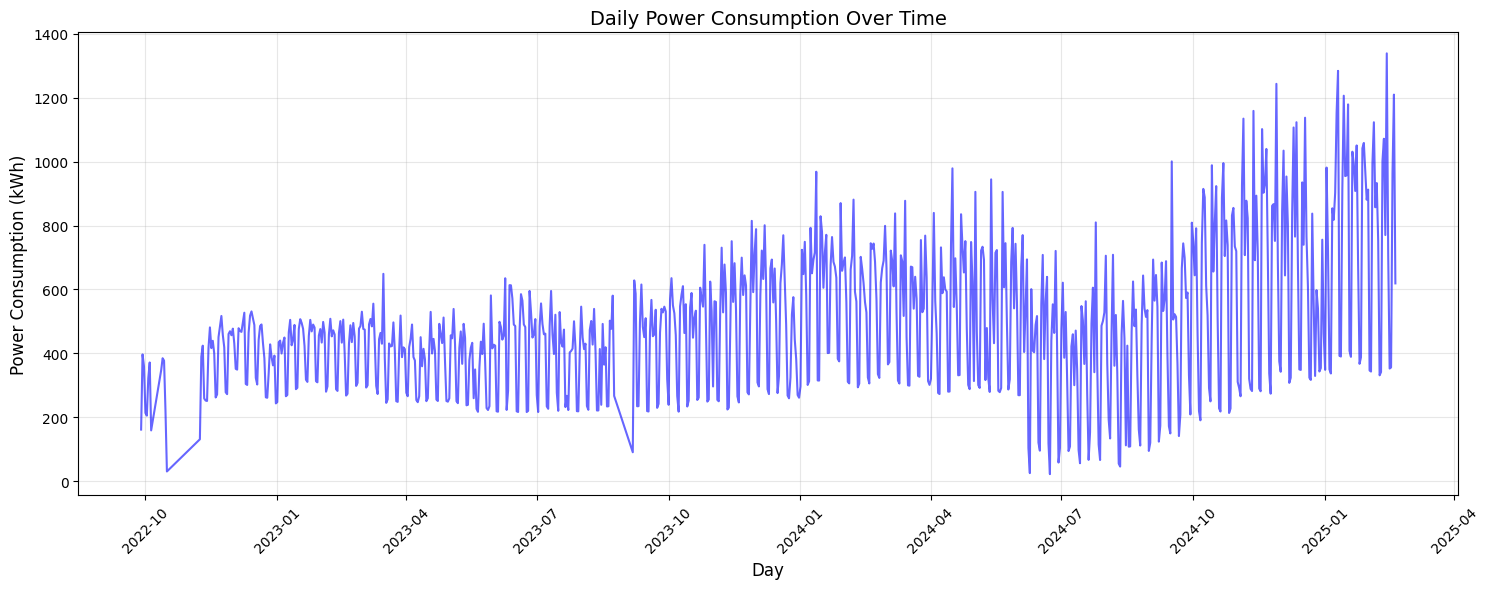

In [35]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('api_data/aggregated_daily_measurements.csv')
df.set_index("Day", inplace=True)
df.index = pd.to_datetime(df.index)

# Combine solar and grid readings, excluding solar before June 2024
df['Total_consumption'] = df['Grid Organi lbc'] 


plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('api_data/aggregated_daily_measurements.csv')
df.set_index("Day", inplace=True)
df.index = pd.to_datetime(df.index)

# Combine solar and grid readings, excluding solar before June 2024
df['Total_consumption'] = df['Grid Organi lbc'] + df['Solar'].where(df.index >= '2024-06-01', 0)

# Drop unwanted columns
df.drop(['Chargers achteraan', 'Solar', 'Chargers', 'Grid Organi lbc'], axis=1, inplace=True)
df.index = df.index.normalize()

# Create a complete date range (including missing dates)
start_date = df.index.min()
end_date = max(df.index.max(), pd.Timestamp('2023-09-06'))  # Extend to Period 2 end
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df = df.reindex(full_date_range)  # Add missing dates as NaN

# Add day of the week
df['day_of_week'] = df.index.dayofweek  # 0=Monday, 6=Sunday

# --- Define Periods ---
# Period 1 (to remove)
period1_start = '2022-09-28'
period1_end = '2022-11-08'
df.loc[period1_start:period1_end, 'Total_consumption'] = np.nan  # Mark for removal

df_period1 = df.loc[period1_start:period1_end].copy()
df = df.drop(df_period1.index)

# Period 2 (to interpolate)
period2_start = '2023-08-24'
period2_end = '2023-09-06'
df.loc[period2_start:period2_end, 'Total_consumption'] = np.nan  # Mark for interpolation

# Remove Period 1 and Period 2
df_remaining = df.dropna(subset=['Total_consumption'])

# --- KEY CHANGE: Use ONLY 2023 data (excluding Period 2) to calculate averages ---
df_remaining_2023 = df_remaining[df_remaining.index.year == 2023]  # Filter to 2023
weekly_avg = df_remaining_2023.groupby('day_of_week')['Total_consumption'].mean()

# Fill Period 2 NaN values with 2023 day-of-week averages
for date in pd.date_range(period2_start, period2_end):
    if pd.isna(df.loc[date, 'Total_consumption']):
        day = date.dayofweek
        df.loc[date, 'Total_consumption'] = weekly_avg[day]

# Handle "wrong_solar" dates (replace with manual values)
wrong_solar_dates = pd.to_datetime([
    '2024-06-08', '2024-06-09', '2024-06-15',
    '2024-06-16', '2024-06-22', '2024-06-23'
])
manual_values = {
    '2024-06-08': 189.52,
    '2024-06-09': 208.01,
    '2024-06-15': 189.52,
    '2024-06-16': 208.01,
    '2024-06-22': 189.52,
    '2024-06-23': 208.01,
}

# Replace values for "wrong_solar" dates
for date in wrong_solar_dates:
    df.loc[date, 'Total_consumption'] = manual_values[date.strftime('%Y-%m-%d')]

# --- Final Cleanup ---
# Drop the 'day_of_week' column (no longer needed)
df = df.drop(columns=['day_of_week'])

# Reset index to make 'Day' a column (not an index)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Day'}, inplace=True)

# Save the final DataFrame (only 'Day' and 'Total_consumption')
df[['Day', 'Total_consumption']].to_csv('api_data/daily_cleaned3.csv', index=False)

# Display the first few rows
print("Final DataFrame:")
print(df.head())

Final DataFrame:
         Day  Total_consumption
0 2022-11-09           389.0860
1 2022-11-10           424.0817
2 2022-11-11           258.9267
3 2022-11-12           252.3417
4 2022-11-13           251.0023


In [31]:
df.isna().sum()

Day                  0
Total_consumption    0
dtype: int64

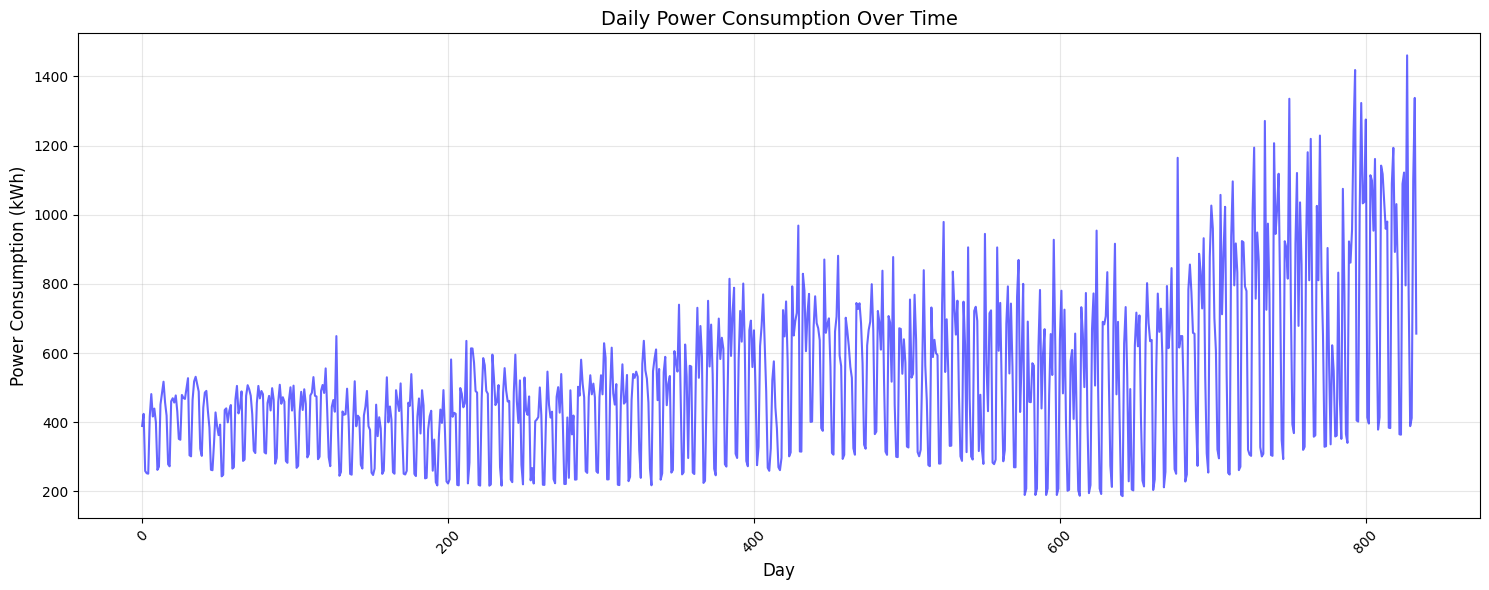

,Day,Total_consumption
0,2022-11-09,389.0860
1,2022-11-10,424.0817
2,2022-11-11,258.9267
3,2022-11-12,252.3417
4,2022-11-13,251.0023
...,...,...
829,2025-02-15,388.5460
830,2025-02-16,412.1156
831,2025-02-17,1101.3619
832,2025-02-18,1337.5922


In [32]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df

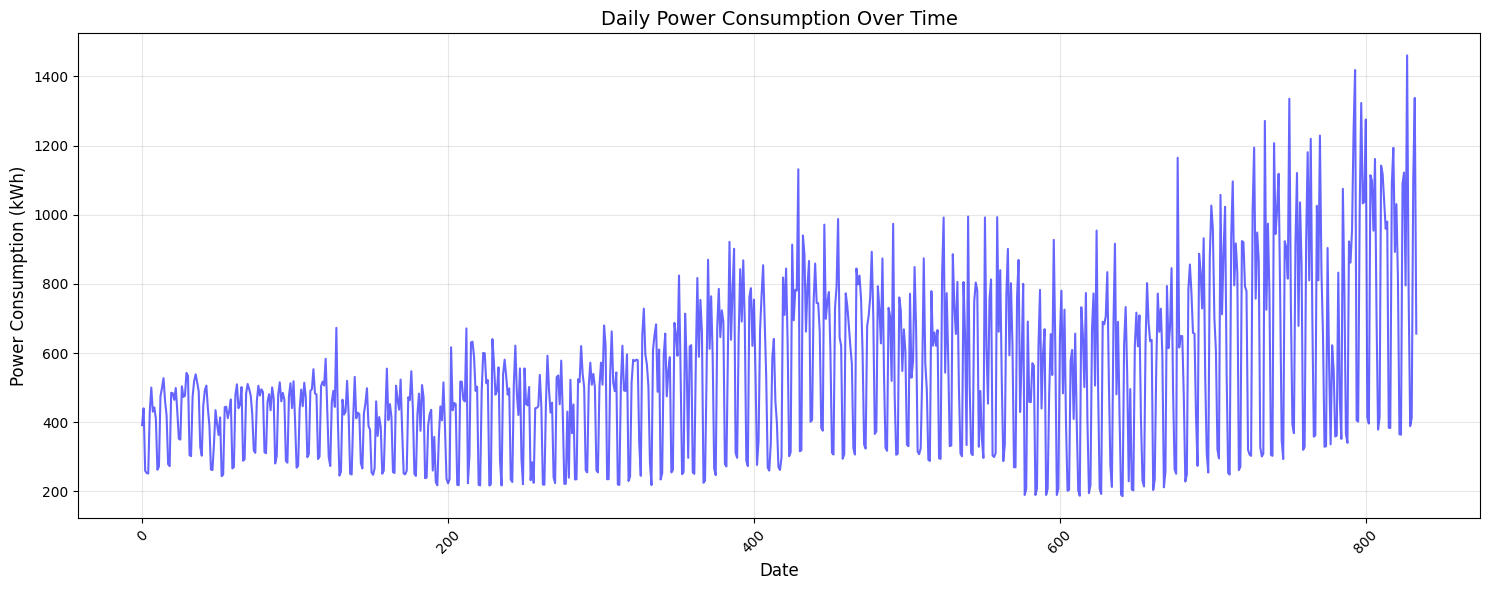

,Day,Total_consumption
0,2022-11-09,391.4783
1,2022-11-10,439.9409
2,2022-11-11,259.4419
3,2022-11-12,252.8694
4,2022-11-13,251.5286
...,...,...
829,2025-02-15,388.5460
830,2025-02-16,412.1156
831,2025-02-17,1101.3619
832,2025-02-18,1337.5922


In [12]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df

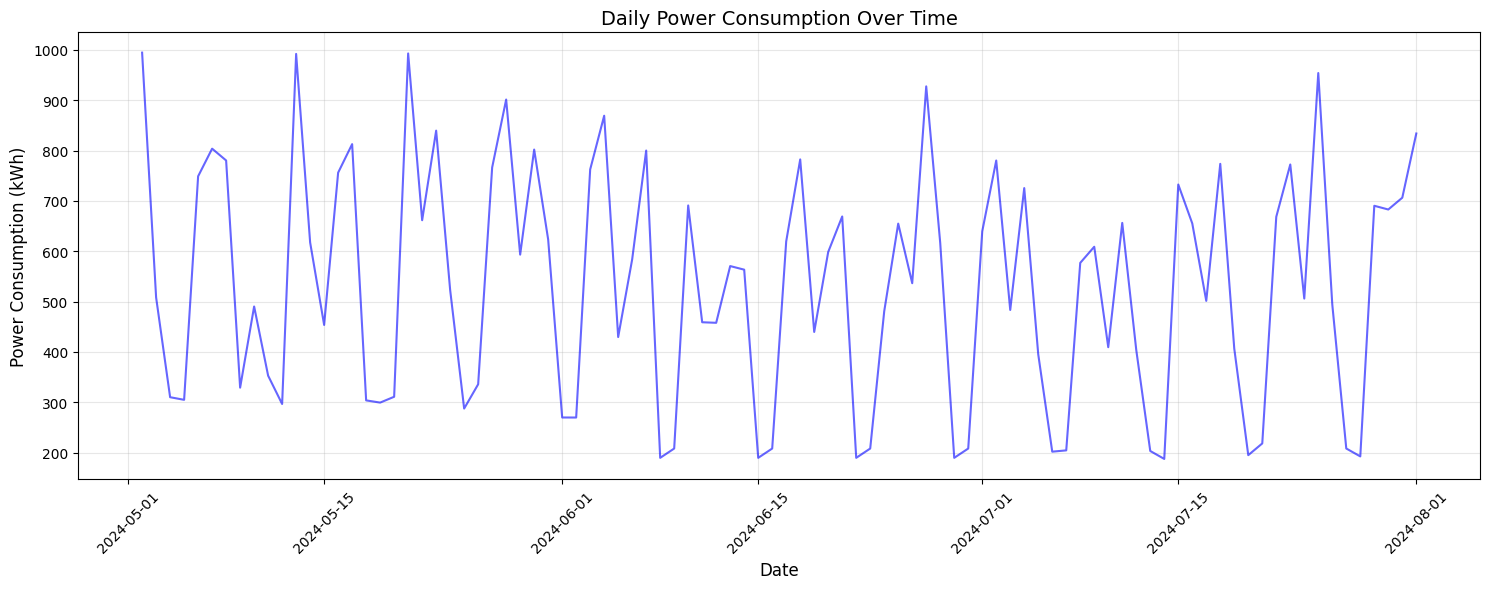

In [15]:
# Ensure the index is a DatetimeIndex first
df.index = pd.to_datetime(df.index)

# Filter the DataFrame by the date range
df_filtered = df_final.loc['2024-05-01 12:00:00':'2024-08-01 12:00:00']

plt.figure(figsize=(15, 6))
plt.plot(df_filtered.index, df_filtered['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()